In [1]:
# lookup index in sorted values
import bisect

# io
import netCDF4
import pyugrid
import rasterio
import rasterio.plot

# computing
import numpy as np
import shapely.geometry
import pandas

# notebook extensions
from ipywidgets import interact, interactive, fixed
import tqdm

# plotting
import cmocean.cm
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style
# matplotlib.style.use('ggplot')

%matplotlib inline

In [2]:
# tiff file that has a correction for the 1d bathymetry (deburned channels) 
# original bathymetry with burned streams is named 'dem_3Di_2272015.tif'
dem_filename = '/Users/baart_f/models/kockengen/fm/AHN2_FM.tif'
fm_filename = '/Users/baart_f/models/kockengen/fm/1d2d_map.nc'
t = 1
face_idx = 3701
n_lnx_1d = 7850 # number of 1d links
n_ndx_1d = 7270 # number of 1d nodes

bounds_x = 124500, 126400
bounds_y = 462500, 464200


This notebook gives an example of how to apply a subgrid technique to an arbitrary numerical model result. 
A flow field is computed using a course schematization. In this example the coarse model computes on a 50m x 50m resolution. The dem is available at 0.5m resolution. So the question is, how do we take into account the high resolution dem after the model has already determined the volumes and fluxes in the coarse grid cells. 

We take the approach of redistrbuting the volumes by filling up the detailed bathymetry from the bottom.
Other approaches are to fill the bathymetry using an interpolated function or from the cell edge with the largest volume difference. 

Advantages of this method over other methods:
- Only computed for flooded areas
- Can be applied a posteriori. No need to implement subgridding in the model.
- Flexibility in detail (only compute on visualization)


Dem
====
Read the high detailed dem file

In [3]:
# dictionary to store grid information
def read_dem(dem_filename):
    dem = {}
    with rasterio.open(dem_filename) as src:
        # read band 0 (1-based)
        band = src.read(1, masked=True)
        dem['band'] = band
    # pixel sizes
    dem['dxp'] = src.affine.a
    dem['dyp'] = -src.affine.e
    dem['affine'] = src.affine
    def world2px(xy):
        xy_t = (xy - (affine.xoff, affine.yoff)) / (affine.a, affine.e)
        return xy_t

    dem['world2px'] = lambda xy: np.vstack((~dem['affine']) * (xy[:,0], xy[:,1])).T.astype('int')
    dem['px2world'] = lambda xy: np.vstack((dem['affine']) * (xy[:,0], xy[:,1])).T

    # extent for imshow
    dem['extent'] = rasterio.plot.plotting_extent(src)
    return dem


Model
=====

Read the model output

In [4]:
def read_ugrid(fm_filename):
    ugrid = pyugrid.UGrid.from_ncfile(fm_filename, 'mesh2d')
    faces = ugrid.faces
    face_centers = ugrid.face_coordinates
    nodes = ugrid.nodes
    face_coordinates = nodes[faces]
    return dict(
        face_coordinates=face_coordinates,
        face_centers=face_centers,
        faces=faces
    )
def get_vars(fm_filename, t):
    ds = netCDF4.Dataset(fm_filename)
    s1 = ds.variables['mesh2d_s1'][t]
    waterdepth = ds.variables['mesh2d_waterdepth'][t]
    vol1 = ds.variables['mesh2d_vol1'][t]
    return dict(
        s1=s1,
        vol1=vol1,
        waterdepth=waterdepth
    )


The subgrid correction
=======================

In [5]:
# grid dem mapping
def data_for_idx(face_idx, dem, grid, data, correction=0):
    face = grid['face_coordinates'][face_idx]
    affine = dem['affine']
    idx = (face - (affine.xoff, affine.yoff)) / (affine.a, affine.e)
    i_min, i_max = int(idx[:,0].min()), int(idx[:,0].max()) 
    j_min, j_max = int(idx[:,1].min()), int(idx[:,1].max()) 
    dem_i = dem['band'][j_min:j_max, i_min:i_max]
    vol_i = data['vol1'][face_idx] + correction
    data = dict(
        face=face,
        dem=dem_i,
        vol=vol_i
    )
    return data


In [6]:
def subgrid_waterdepth(face_idx, dem, grid, data, tables, correction): 
    try:
        # tables is a dataframe
        hist = tables.ix[face_idx]
    except AttributeError:
        # it is a dictionary or list
        hist = tables[face_idx]
    n = hist["n"]
    bins = hist["bins"]
    if bins is None:
        return None
    volume_table = hist["volume_table"]
    cum_volume_table = hist["cum_volume_table"]

    dem_i = hist['dem']
    face = hist['face']
    
    
    # this part is once volume is known
    vol_i = data['vol1'][face_idx] + correction
    
    fill_idx = bisect.bisect(cum_volume_table, vol_i)
    remaining_volume = vol_i - cum_volume_table[fill_idx - 1]
    pixel_area = dem['dxp'] * dem['dyp']
    face_area = np.prod(dem_i.shape) * pixel_area
    
    if fill_idx >= len(cum_volume_table):
        remaining = (vol_i - cum_volume_table[-1]) / face_area 
        target_level = bins[-1] + remaining
    else:
        remaining_volume_fraction = remaining_volume / volume_table[fill_idx]
        target_level = bins[fill_idx] + remaining_volume_fraction * (bins[fill_idx + 1] - bins[fill_idx])



    # first cell that is not completely filled

    waterdepth_i = np.zeros_like(dem_i)
    idx = dem_i < target_level
    waterdepth_i[idx] = (target_level - dem_i[idx]) 
    return waterdepth_i


Example
======

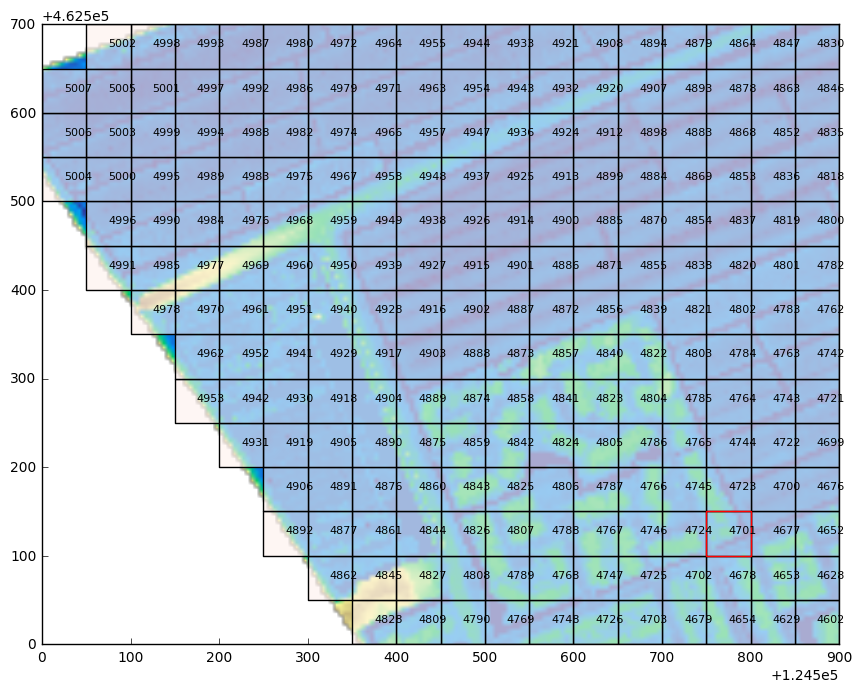

In [7]:
# read the dem
dem = read_dem(dem_filename)
grid = read_ugrid(fm_filename)
data = get_vars(fm_filename, t=t)


domain = data['waterdepth'].min(), data['waterdepth'].max()
N = matplotlib.colors.Normalize(*domain)
colors = matplotlib.cm.RdPu(N(data['waterdepth']))
colors[data['waterdepth'] < 0.03, 3] = 0.1
colors[:, 3] = 0.6


polys = matplotlib.collections.PolyCollection(verts=grid['face_coordinates'], facecolors=colors, edgecolors='black')
fig, ax = plt.subplots(figsize=(13, 8))
ax.imshow(
    dem['band'][::10,::10], 
    cmap=matplotlib.cm.terrain, 
    vmin=-2, 
    vmax=2,
    extent=dem['extent']
)
ax.add_collection(polys)
ax.autoscale()
#x = np.array([(list(x) + [None]) for x in face_coordinates[...,0]]).flat
# y = np.array([(list(y) + [None]) for y in face_coordinates[...,1]]).flat
# ax.fill(x, y, data=hs, edgecolor='none')
bounds_x = 124500, 125400
bounds_y = 462500, 463200
for i, xy in enumerate(grid['face_centers']):
    if bounds_x[0] < xy[0] < bounds_x[1] and bounds_y[0] < xy[1] < bounds_y[1]:
        ax.text(xy[0], xy[1], str(i), fontsize=8)
ax.set_xlim(*bounds_x)
ax.set_ylim(*bounds_y)
ax.fill(grid['face_coordinates'][4701][:, 0], grid['face_coordinates'][4701][:, 1], edgecolor='red', facecolor='none')

# ax.set_xlim(tables[4714]['extent'][0], tables[4714]['extent'][1])
#ax.set_ylim(tables[4714]['extent'][2], tables[4714]['extent'][3])

In [8]:
# compute cache of histograms per cell
idx = range(grid['face_coordinates'].shape[0])
faces = grid['face_coordinates'][idx]
tables = {}
for id_, face in zip(idx, tqdm.tqdm_notebook(faces)):
    affine = dem['affine']
    face_px = dem['world2px'](face)
    face_px2slice = np.s_[
        face_px[:,1].min():face_px[:,1].max(),
        face_px[:,0].min():face_px[:,0].max()
    ]
    dem_i = dem['band'][face_px2slice]
    if not dem_i.mask.all():
        n, bins = np.histogram(dem_i.flatten(), bins=10)
        volume_table = np.abs(affine.a * affine.e) * n * np.diff(bins)
        cum_volume_table = np.cumsum(volume_table)
    else:
        n, bins = None, None
        volume_table = None,
        cum_volume_table = None
    extent = [
        face[:,0].min(), 
        face[:,0].max(), 
        face[:,1].min(), 
        face[:,1].max()
    ]
    record = dict(
        id=id_,
        slice=face_px2slice,
        face=face,
        dem=dem_i,
        volume_table=volume_table,
        cum_volume_table=cum_volume_table,
        n=n,
        extent=extent,
        bins=bins
    )
    tables[id_] = record
    
tables = pandas.DataFrame.from_records(list(tables.values())).set_index('id')
tables.head()

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


,bins,cum_volume_table,dem,extent,face,n,slice,volume_table
id,,,,,,,,
0,"[-3.40282306074e+38, -3.06254075466e+38, -2.72...","[2.13527147061e+39, 2.13527147061e+39, 2.13527...","[[0.893, 0.86, 0.838, 0.832, 0.816, 0.815, 0.8...","[129450.0, 129500.0, 462100.0, 462150.0]","[[129450.0, 462100.0], [129500.0, 462100.0], [...","[251, 0, 0, 0, 0, 0, 0, 0, 0, 9749]","(slice(5391, 5491, None), slice(10030, 10130, ...","[2.13527147061e+39, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
1,"[-3.90000009537, -3.35480008125, -2.8096000671...","[11.1766002893, 25.4881006598, 26.305900681, 7...","[[-1.087, -1.126, -1.083, -1.079, -1.037, -1.0...","[129400.0, 129450.0, 462100.0, 462150.0]","[[129400.0, 462100.0], [129450.0, 462100.0], [...","[82, 105, 6, 347, 1096, 5861, 1116, 528, 194, ...","(slice(5391, 5491, None), slice(9930, 10030, N...","[11.1766002893, 14.3115003705, 0.817800021172,..."
2,"[-3.20000004768, -2.8395000428, -2.47900003791...","[28.5696253873, 28.5696253873, 28.5696253873, ...","[[-0.755, -0.914, -0.942, -0.98, -1.057, -1.02...","[129350.0, 129400.0, 462050.0, 462100.0]","[[129350.0, 462050.0], [129400.0, 462050.0], [...","[317, 0, 0, 0, 16, 763, 5467, 2026, 774, 637]","(slice(5491, 5591, None), slice(9830, 9930, No...","[28.5696253873, 0.0, 0.0, 0.0, 1.44200001955, ..."
3,"[-3.40282306074e+38, -3.06254075466e+38, -2.72...","[3.53893598317e+39, 3.53893598317e+39, 3.53893...","[[0.694, 0.68, 0.677, 0.67, 0.657, 0.657, 0.63...","[129400.0, 129450.0, 462150.0, 462200.0]","[[129400.0, 462150.0], [129450.0, 462150.0], [...","[416, 0, 0, 0, 0, 0, 0, 0, 0, 9584]","(slice(5291, 5391, None), slice(9930, 10030, N...","[3.53893598317e+39, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
4,"[-2.34999990463, -2.1759999156, -2.00199992657...","[0.347999978065, 0.347999978065, 0.39149997532...","[[-1.085, -1.069, -1.043, -1.074, -1.053, -1.0...","[129350.0, 129400.0, 462100.0, 462150.0]","[[129350.0, 462100.0], [129400.0, 462100.0], [...","[8, 0, 1, 379, 136, 309, 1259, 7010, 887, 11]","(slice(5391, 5491, None), slice(9830, 9930, No...","[0.347999978065, 0.0, 0.0434999972582, 16.4864..."


 Compute volume relocation
 
 Cell volume -> pixel cumalitive volume (over threshold)
 cell 4701

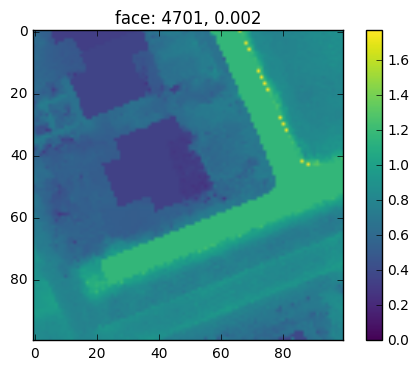

In [9]:


def plot_waterdepth(face_idx=(4701-100, 4701+100), correction=(0, 2000)):
    import time
    tic = time.time()
    waterdepth_i = subgrid_waterdepth(face_idx, dem=dem, grid=grid, data=data, correction=correction, tables=tables)
    toc = time.time()
    plt.imshow(waterdepth_i, cmap='viridis', vmin=0)    
    plt.title("face: %d, %.3f" % (face_idx, toc - tic))
    plt.colorbar()
_ = interact(plot_waterdepth)

Problems

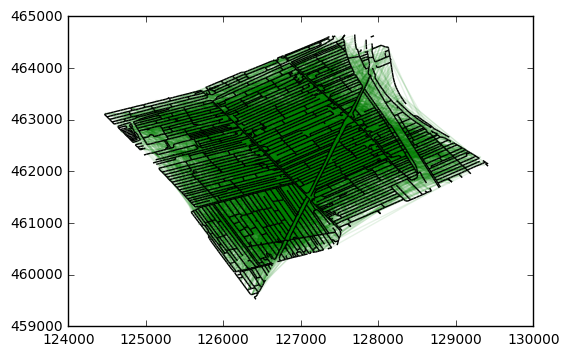

In [10]:
ugrid = pyugrid.UGrid.from_ncfile(fm_filename, mesh_name='mesh1d')
ds = netCDF4.Dataset(fm_filename)
vol = ds.variables['mesh1d_vol1'][t]
segments = ugrid.nodes[ugrid.edges]
N = matplotlib.colors.Normalize(vol.min(), vol.max())
colors = matplotlib.cm.viridis(N(vol))
fig, ax = plt.subplots()

lines = matplotlib.collections.LineCollection(segments, edgecolor='green', alpha=0.1)
ax.add_collection(lines)
lines = matplotlib.collections.LineCollection(segments[:n_lnx_1d,...], edgecolor='black')
ax.add_collection(lines)
ax.autoscale()


Improvements


In [11]:
# node_vars = ds.variables['mesh1d'].node_coordinates.split()
# for var in node_vars:
#     bounds_var = ds.variables[var].bounds
#     grid[bounds_var] = ds.variables[bounds_var]
grid['bounds_x'] = ds.variables['mesh1d_FlowElemContour_x'][:n_ndx_1d]
grid['bounds_y'] = ds.variables['mesh1d_FlowElemContour_y'][:n_ndx_1d]

In [13]:

verts = []
for x, y in zip(grid['bounds_x'], grid['bounds_y']):
    vertices = np.c_[x[~x.mask], y[~y.mask]]
    assert (x.mask == y.mask).all()
    verts.append(vertices)
vol = ds.variables['mesh1d_vol1'][t, :n_ndx_1d]
N = matplotlib.colors.Normalize(vol.min(), vol.max())
colors = matplotlib.cm.Blues(N(vol))


waterdepth_1d = ds.variables['mesh1d_waterdepth'][t, :]
N = matplotlib.colors.Normalize(0, 3.0)
colors = matplotlib.cm.viridis(N(waterdepth_1d))

polys = matplotlib.collections.PolyCollection(verts, facecolors=colors, edgecolors='none')




(462500, 463200)

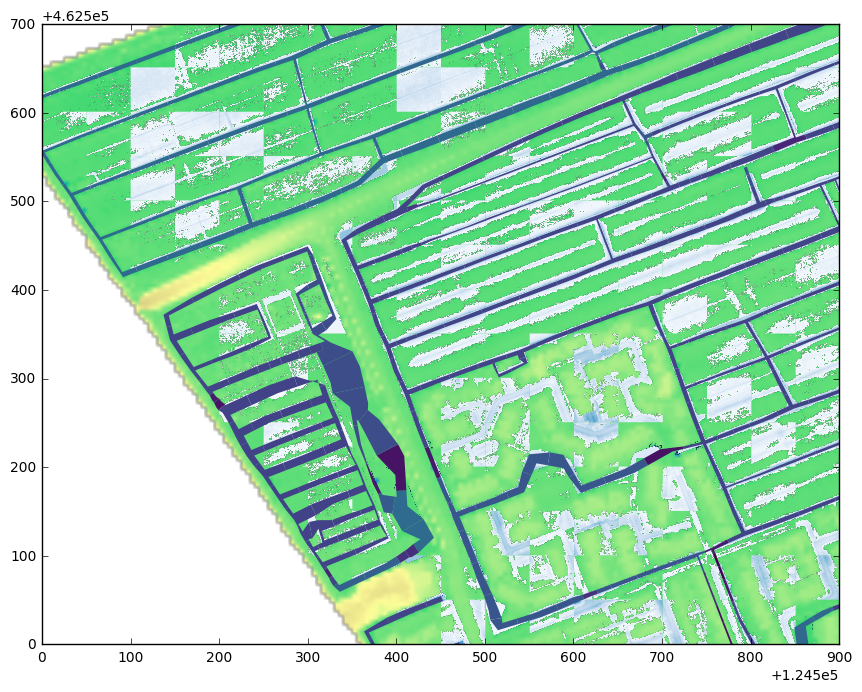

In [14]:
fig, ax = plt.subplots(figsize=(13, 8))
ax.imshow(
    dem['band'][::10,::10], 
    cmap=matplotlib.cm.terrain, 
    vmin=-5, 
    vmax=5,
    extent=dem['extent']
)


for face_idx in iter(tables.index):
    row = tables.ix[face_idx]
    if not (
        (bounds_x[0] <= row['extent'][0] < bounds_x[1]) 
        or (bounds_x[0] <= row['extent'][1] < bounds_x[1])
    ):
        continue
    if not (
        (bounds_y[0] <= row['extent'][2] < bounds_y[1]) 
        or (bounds_y[0] <= row['extent'][3] < bounds_y[1])
    ):
        continue
    waterdepth_i = subgrid_waterdepth(face_idx, dem=dem, grid=grid, data=data, correction=100, tables=tables)
    if waterdepth_i is None:
        # cells without dem
        print(face_idx)
        continue
    # lookup row, so we know where to plot

    ax.imshow(np.ma.masked_less_equal(waterdepth_i, 0.0), extent=row['extent'], vmin=0, vmax=1, cmap='Blues')
ax.autoscale()

colors[:,3] = 1.0
s = np.s_[:]
polys = matplotlib.collections.PolyCollection(verts[s], facecolors=colors[s], edgecolors='none', closed=False)
ax.add_collection(polys)
    
ax.set_xlim(*bounds_x)
ax.set_ylim(*bounds_y)